<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/DINOv2/Fine_tune_DINOv2_for_image_classification_%5Bminimal%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up environment

In [ ]:
!pip install -q transformers[torch] datasets

In [ ]:
# see https://twitter.com/huggingface/status/1737533693906870668
# which now enables to automatically login :)
!pip install -q --upgrade huggingface_hub

## Load dataset

In [ ]:
from datasets import load_dataset

# see https://huggingface.co/docs/datasets/image_dataset to load your own custom dataset
dataset = load_dataset("timm/oxford-iiit-pet")

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'image_id', 'label_cat_dog'],
        num_rows: 3680
    })
    test: Dataset({
        features: ['image', 'label', 'image_id', 'label_cat_dog'],
        num_rows: 3669
    })
})

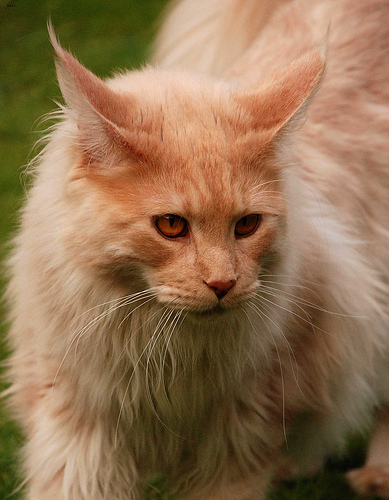

In [ ]:
example = dataset["train"][0]
example["image"]

In [ ]:
example["label"]

20

In [ ]:
labels = dataset["train"].features["label"].names
id2label = {id: label for id, label in enumerate(labels)}
label2id = {label: id for id, label in enumerate(labels)}
print(id2label)

{0: 'abyssinian', 1: 'american_bulldog', 2: 'american_pit_bull_terrier', 3: 'basset_hound', 4: 'beagle', 5: 'bengal', 6: 'birman', 7: 'bombay', 8: 'boxer', 9: 'british_shorthair', 10: 'chihuahua', 11: 'egyptian_mau', 12: 'english_cocker_spaniel', 13: 'english_setter', 14: 'german_shorthaired', 15: 'great_pyrenees', 16: 'havanese', 17: 'japanese_chin', 18: 'keeshond', 19: 'leonberger', 20: 'maine_coon', 21: 'miniature_pinscher', 22: 'newfoundland', 23: 'persian', 24: 'pomeranian', 25: 'pug', 26: 'ragdoll', 27: 'russian_blue', 28: 'saint_bernard', 29: 'samoyed', 30: 'scottish_terrier', 31: 'shiba_inu', 32: 'siamese', 33: 'sphynx', 34: 'staffordshire_bull_terrier', 35: 'wheaten_terrier', 36: 'yorkshire_terrier'}


## Load the model

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

model_name = "facebook/dinov2-base"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name, id2label=id2label, label2id=label2id)

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Prepare dataset for the model

In [ ]:
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, ColorJitter, ToTensor, Normalize
import torch

# make sure to use the appropriate image mean, std and interpolation
# of the inference processor
mean = processor.image_mean
std = processor.image_std
interpolation = processor.resample

# for training, we use some image transformations from Torchvision
# feel free to use other libraries like Albumentations or Kornia here
train_transform = Compose([
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=interpolation),
    RandomHorizontalFlip(p=0.5),
    ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4)),
    ToTensor(),
    Normalize(mean=mean, std=std),
])

In [ ]:
def prepare(batch, mode="train"):
  # get images
  images = batch["image"]

  # prepare for the model
  if mode == "train":
    images = [train_transform(image.convert("RGB")) for image in images]
    pixel_values = torch.stack(images)
  elif mode == "test":
    pixel_values = processor(images, return_tensors="pt").pixel_values
  else:
    raise ValueError(f"Mode {mode} not supported")

  inputs = {}
  inputs["pixel_values"] = pixel_values
  inputs["labels"] = torch.tensor(batch["label"])

  return inputs

# set num_proc equal to the number of CPU cores on your machine
# see https://docs.python.org/3/library/multiprocessing.html#multiprocessing.cpu_count
train_dataset = dataset["train"].map(prepare, num_proc=2, batched=True, batch_size=20, fn_kwargs={"mode":"train"})
eval_dataset = dataset["test"].map(prepare, num_proc=2, batched=True, batch_size=20, fn_kwargs={"mode":"test"})

In [ ]:
train_dataset.set_format("torch")
eval_dataset.set_format("torch")

In [ ]:
train_dataset[0]["pixel_values"].shape

torch.Size([3, 224, 224])

In [ ]:
train_dataset[0]["labels"]

tensor(20)

## Train the model

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    accuracy = accuracy_score(y_pred=predictions, y_true=eval_pred.label_ids)
    return {"accuracy": accuracy}

In [ ]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"{model_name}-finetuned-oxford",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [ ]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.985500,0.596194,0.801036
2,0.426100,0.488605,0.853639
3,0.096300,0.266184,0.922050


TrainOutput(global_step=690, training_loss=0.7261388156293095, metrics={'train_runtime': 1132.513, 'train_samples_per_second': 9.748, 'train_steps_per_second': 0.609, 'total_flos': 8.638588166868173e+17, 'train_loss': 0.7261388156293095, 'epoch': 3.0})

In [ ]:
!pip show torch

Name: torch
Version: 2.1.0+cu121
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, triton, typing-extensions
Required-by: accelerate, fastai, torchaudio, torchdata, torchtext, torchvision
